#Assignment (CIFAR10 image dataset with tensorflow) on GOOGLE COLAB

In [ ]:
#install tensorflow with GPU 
!pip install tensorflow-gpu==2.1.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


#import necessary packages

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import os

#using tensorflow keras as backend to build neural nets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.datasets import cifar10
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report   #confusion matrix to find the accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger

from PIL import Image

%matplotlib inline

#Download dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Predictors Training set shape:', X_train.shape)
print('Targets Training set shape:', y_train.shape)
print(' Predictors Test set shape:', X_test.shape)
print('Targets Test set shape:', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Predictors Training set shape: (50000, 32, 32, 3)
Targets Training set shape: (50000, 1)
 Predictors Test set shape: (10000, 32, 32, 3)
Targets Test set shape: (10000, 1)


# Define the labels/tagets/classes of the dataset

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

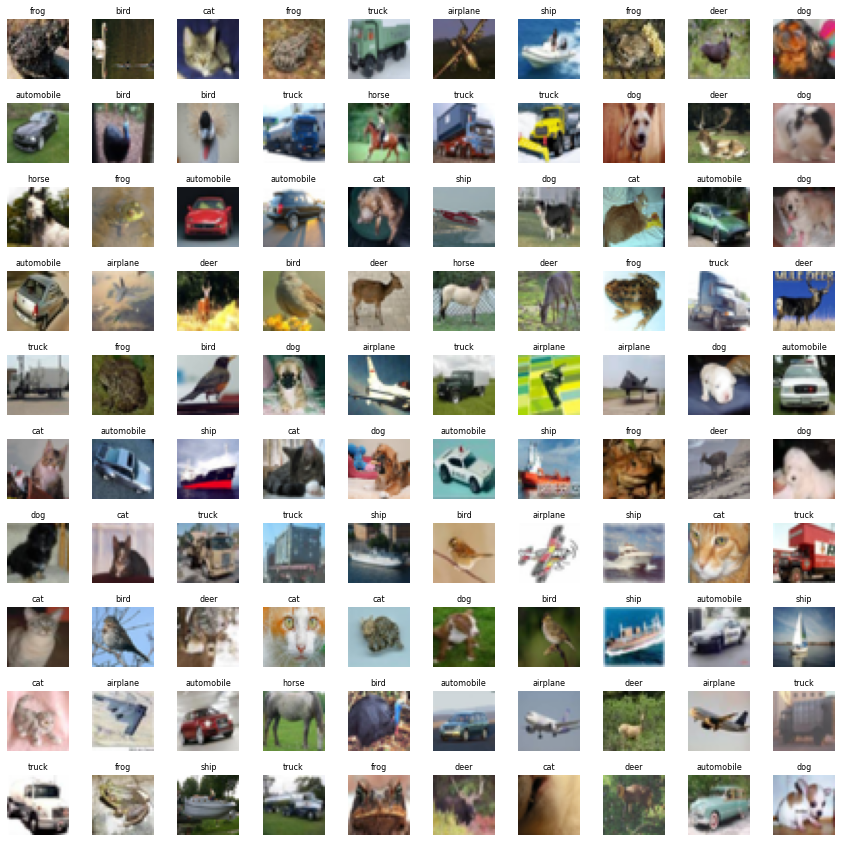

In [ ]:

# Let's view more images in a grid format Define the dimensions of the plot grid 
Row_grid = 10
Col_grid = 10
fig, axes = plt.subplots(Row_grid, Col_grid, figsize = (15,15))
axes = axes.ravel() # flaten the 10x 10rray matrix into 100 
n_train = len(X_train) # get the length of the train dataset

for i in np.arange(0, Row_grid * Col_grid):
    index = np.random.randint(0, n_train) # Select a random number
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(class_names[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


# normalization 

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# X_train

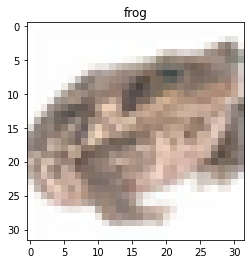

In [ ]:
#normalized form  image
plt.title(class_names[int(y_test[142])])
plt.imshow(X_test[142])

#Split training dataset into train and validation set (chunks)

In [ ]:
#10% from training set has been reduced and will be used for validation (Testing the model accuracy)
# 5000 images for validation
#45000 images for training 
#10000 images for testing (prediction on unknown dataset)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1) 


#perform one hot encoding on target lables 

In [ ]:
num_classes = 10  #here 10 classes/lables are avaiable 
y_cat_trainValid = tf.keras.utils.to_categorical(y_train, num_classes)
y_cat_testValid = tf.keras.utils.to_categorical(y_valid, num_classes)

#Build Neural Net (Design Model)

In [ ]:
model = Sequential()

# Convolutional Layer
#First conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
#Normalize the inputs
model.add(BatchNormalization())
#second conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer (reduce the redundant parameters)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

#third conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
#fourth conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#fifth conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
#sixth conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0003, decay=1e-6), 
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

#Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, 
    mode='auto', min_delta=1e-10, cooldown=0, min_lr=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=12, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

#Log information
csv_logger = tf.keras.callbacks.CSVLogger(
    'cifar10_results.csv', separator='|', append=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "modelcheckpoint.hdf5", save_weights_only=True, mode='auto', 
    save_freq='epoch', verbose=1
)

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_trainValid, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

history = model.fit(
    train_generator, 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=50,  
    validation_data=(X_valid, y_cat_testValid), 
    callbacks=[csv_logger, reduce_learning_rate, early_stopping, model_checkpoint],
    verbose=1
)


  ...
    to  
  ['...']
Train for 1406 steps, validate on 5000 samples
Epoch 1/50
1404/1406 [============================>.] - ETA: 0s - loss: 1.7014 - accuracy: 0.3940
Epoch 00001: saving model to modelcheckpoint.hdf5
1406/1406 [==============================] - 51s 36ms/step - loss: 1.7010 - accuracy: 0.3941 - val_loss: 1.4839 - val_accuracy: 0.4724
Epoch 2/50
1405/1406 [============================>.] - ETA: 0s - loss: 1.3203 - accuracy: 0.5231
Epoch 00002: saving model to modelcheckpoint.hdf5
1406/1406 [==============================] - 44s 31ms/step - loss: 1.3205 - accuracy: 0.5231 - val_loss: 1.1745 - val_accuracy: 0.5862
Epoch 3/50
1404/1406 [============================>.] - ETA: 0s - loss: 1.1259 - accuracy: 0.5996
Epoch 00003: saving model to modelcheckpoint.hdf5
1406/1406 [==============================] - 44s 32ms/step - loss: 1.1259 - accuracy: 0.5996 - val_loss: 1.0047 - val_accuracy: 0.6432
Epoch 4/50
1404/1406 [============================>.] - ETA: 0s - loss: 0.9959 

#Loss and accuracy analysis while training the model

In [ ]:
import pandas as pd
train_log = pd.read_csv("cifar10_results.csv" , sep="|")  #log file (track all the activity while training the model like error, accuracy)
train_log.tail(10)

,epoch,accuracy,loss,val_accuracy,val_loss
40,40,0.884585,0.331783,0.8628,0.432056
41,41,0.884362,0.330105,0.8534,0.439444
42,42,0.884940,0.328960,0.8610,0.434386
43,43,0.891034,0.313587,0.8678,0.420726
44,44,0.889166,0.312084,0.8654,0.420794
45,45,0.899996,0.284810,0.8826,0.368129
46,46,0.903509,0.276806,0.8794,0.384409
47,47,0.907201,0.264867,0.8852,0.382591
48,48,0.908402,0.259260,0.8822,0.377297
49,49,0.909313,0.262259,0.8760,0.395536


#Grab the information about the loss , accuracy and learning rate in each epoch (While training the model)  Plot the Graph

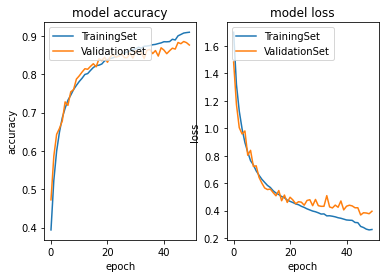

In [ ]:
# Accuracy plot
plt.subplot(121)
plt.plot(train_log['accuracy'])
plt.plot(train_log['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['TrainingSet', 'ValidationSet'], loc='upper left')
# Loss plot
plt.subplot(122)
plt.plot(train_log['loss'])
plt.plot(train_log['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TrainingSet', 'ValidationSet'], loc='upper left')

#Keep all together

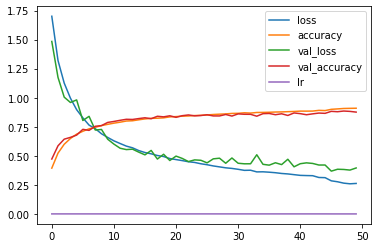

In [ ]:
pd.DataFrame(history.history).plot()

#Find the Model accuracy on Test/Unknown Dataset

In [ ]:
y_test =  tf.keras.utils.to_categorical(y_test, num_classes)
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

10000/10000 [==============================] - 2s 240us/sample - loss: 0.4139 - accuracy: 0.8690
Test loss: 0.4139391183674335
Test accuracy: 86.90%


#Prediction 

In [ ]:
%%time
pred = model.predict(X_test)

CPU times: user 1.72 s, sys: 354 ms, total: 2.07 s
Wall time: 1.84 s


#Accuracy Evaluation using Confusion matrix

In [ ]:
y_pred = np.argmax(pred, axis=1)  #converting into single classsess (reverse from one hot encoding )
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1000
           1       0.92      0.96      0.94      1000
           2       0.88      0.79      0.83      1000
           3       0.79      0.70      0.74      1000
           4       0.86      0.87      0.86      1000
           5       0.86      0.76      0.81      1000
           6       0.76      0.96      0.85      1000
           7       0.93      0.90      0.91      1000
           8       0.94      0.92      0.93      1000
           9       0.89      0.94      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



[[896  10  15   4   7   1  11   7  23  26]
 [  3 957   0   0   0   0   2   0   5  33]
 [ 31   2 791  23  44  23  60   9   7  10]
 [ 14   7  27 700  35  73 100  19   8  17]
 [  9   1  18  16 868   7  60  18   2   1]
 [  6   3  17 113  24 758  54  15   3   7]
 [  4   3  10  10   4   2 964   1   1   1]
 [ 11   0   9  16  31  18   8 897   4   6]
 [ 34  11   6   2   1   1   5   0 922  18]
 [  7  42   3   2   0   0   5   0   4 937]]


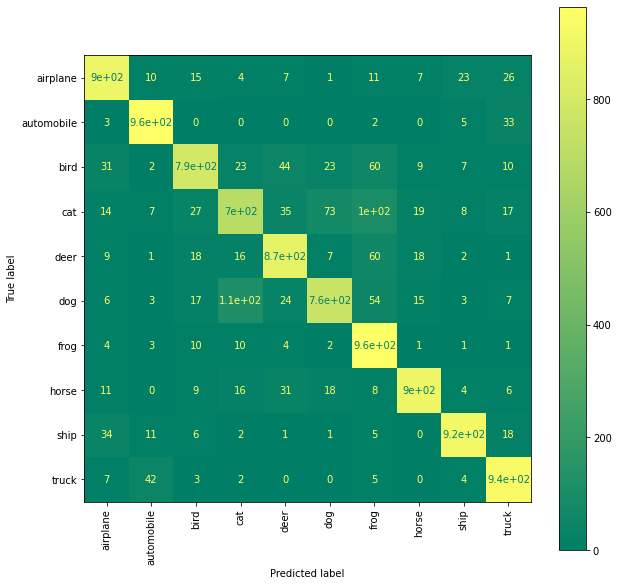

In [ ]:
y_pred = model.predict_classes(X_test)

y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)   #out of 1000 per image
# Define the labels of the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

#Actual prediction 

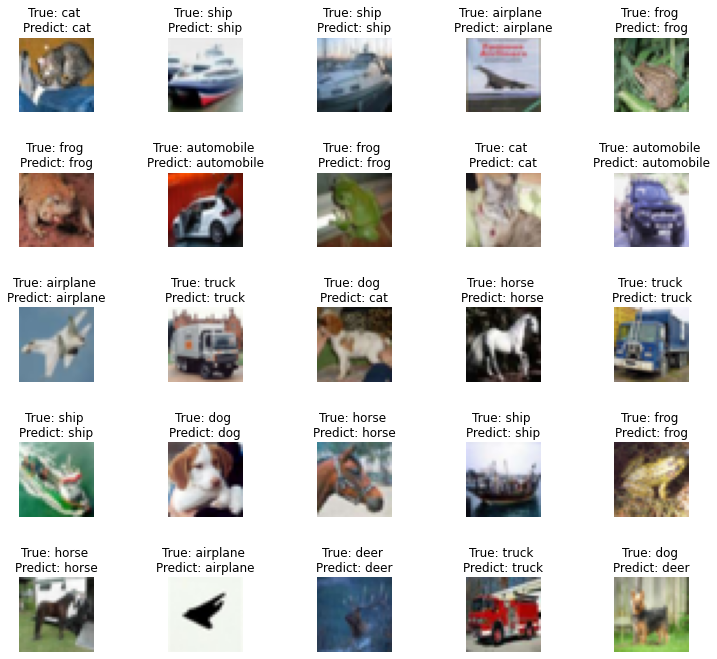

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (class_names[y_true[i]], class_names[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#predicted wrong classes

[False False False ... False False False]


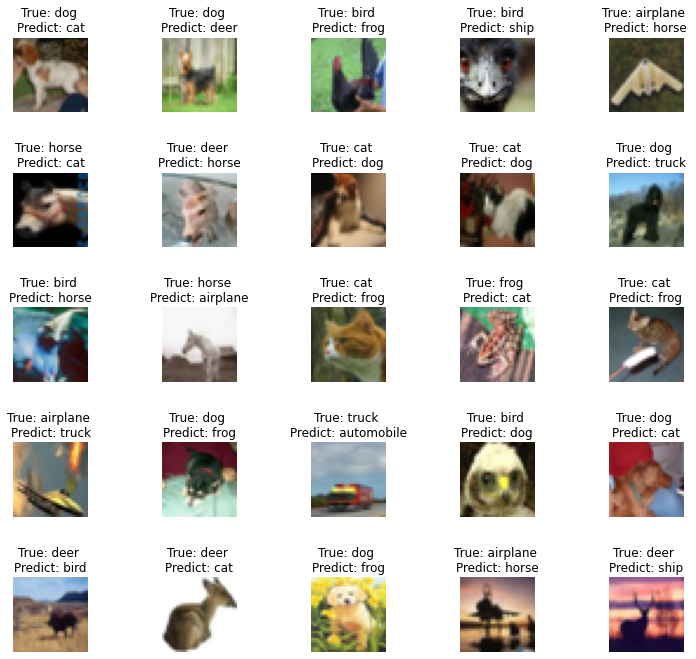

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
errors = y_pred - y_true != 0
print(errors)
miss_pred = np.where(y_pred != y_true)[0]
for i in np.arange(25):
    axes[i].imshow(X_test[miss_pred[i]])
    axes[i].set_title('True: %s \nPredict: %s' % (class_names[y_true[miss_pred[i]]], class_names[y_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


#Save the model

In [ ]:
model.save('cifar10_cnnWeightModel.h5')

In [ ]:
model.save('cifar10Net')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cifar10Net/assets


#Download the model

In [ ]:
from google.colab import files
files.download('cifar10_cnnWeightModel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>